In [1]:
#| export
verbose                       = None
check_memory_usage            = None
time_flag                     = None
window_size_percentage        = None
show_plots                    = None
reset_kernel                  = None
pre_configured_case           = None
case_id                       = None
frequency_factor              = None
frequency_factor_change_alias = None
check_parameters              = True
cuda_device                   = None

--> Todo: Quitar y meter en el docker la instalación cuando no haya problemas de dependencias

In [2]:
#! git clone https://github.com/SalesforceAIResearch/uni2ts.git
#! cd uni2ts | pip install -e '.[notebook]' --no-warn-script-location

## Checking input parameters

In [3]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
verbose: None check_memory_usage None time_flag: None window_size_percentage: None show_plots: None reset_kernel: None pre_configured_case: None case_id: None frequency_factor: None frequency_factor_change_alias None cuda_device None


## Set default input parameter values ensuring no errors
### Values explained below in their natural execution place

In [4]:
#| export
verbose                       = True  if verbose is None else verbose
check_memory_usage            = True  if check_memory_usage is None else check_memory_usage
time_flag                     = True  if time_flag is None else time_flag
window_size_percentage        = False if window_size_percentage is None else window_size_percentage
show_plots                    = True if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
pre_configured_case           = True if pre_configured_case is None else pre_configured_case
case_id                       = 7 if case_id is None else case_id
frequency_factor              = 1 if frequency_factor is None else frequency_factor
frequency_factor_change_alias = True if frequency_factor_change_alias is None else frequency_factor_change_alias
cuda_device                   = 1 if  cuda_device is None else cuda_device

In [5]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
verbose: True check_memory_usage True time_flag: True window_size_percentage: False show_plots: True reset_kernel: False pre_configured_case: True case_id: 7 frequency_factor: 1 frequency_factor_change_alias True cuda_device 1


# Encoder - Moment

> Github repository: https://github.com/moment-timeseries-foundation-model/moment
> Research paper: https://arxiv.org/html/2402.03885v2

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection.
### VsCode update patch
Initial notebook setup when using VSCode.

In [6]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables

- `verbose`. If ` > 0` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [7]:
#| export
import dvats.config as cfg_

In [8]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


## Main code
### Import libraries

In [9]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb
from momentfm import MOMENTPipeline

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedOutputStream size changed, may indicate binary 


Octave is ready <oct2py.core.Oct2Py object at 0x7f5613b99900>

















In [10]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_next_multi

### Initialize and Configurate Artifact

In [11]:
#| export
wandb_api = wandb.Api()

#### Setup CUDA

In [12]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 9
GPU | Used mem: 24
GPU | Memory Usage: [███████-------------] 38%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

--> Todo: adaptar a MOMENT

In [13]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        verbose = verbose, 
        both = verbose > 0,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

mask_sync: False
epochs: 100
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest -> mi-santamaria/deepvats/toy:latest
norm_use_by_single_batch is missing in original dict | (False,) 
data_fpath is missing in original dict | ~/data/toy.csv 
alias: PulsusParadoxus-SP02 -> toy
valid_size: 0.2
analysis_mode: online
artifact_name is missing in original dict | toy 
time_col is missing in original dict | None 
w: 100 -> 30
batch_size: 512 -> 32
stride: 900 -> 1
norm_by_sample: False
norm_use_single_batch: False
mask_future: False
freq is missing in original dict | 1s 
r: 0.71
wandb_group: None
data_cols is missing in original dict | [] 
use_wandb: True
valid_artifact: None
mvp_ws: (15, 100) -> [10, 30]
csv_config is missing in original dict | {} 
mask_stateful: True


### Setup Weights & biases artiffact

In [14]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02c_encoder_moment-embedding"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

runname: 02c_encoder_moment-embedding
alias: toy
analysis_mode: online
batch_size: 32
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [10, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 1
train_artifact: mi-santamaria/deepvats/toy:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None
artifact_name: toy
data_cols: []
data_fpath: ~/data/toy.csv
freq: 1s
time_col: None
csv_config: {}
norm_use_by_single_batch: (False,)


In [15]:
#| export
if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/02c_encoder_moment-embedding.ipynb.


--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


## Split data using Sliding Window & Get training artiffact

### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [16]:
#| export
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")


alias: toy
analysis_mode: online
batch_size: 32
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [10, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 1
train_artifact: mi-santamaria/deepvats/toy:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None
artifact_name: toy
data_cols: []
data_fpath: ~/data/toy.csv
freq: 1s
time_col: None
csv_config: {}
norm_use_by_single_batch: [False]
---> W&B Train Artifact


In [17]:
#| export
import pyarrow.feather as ft
df_train = train_artifact.to_df()
df_train.shape

wandb:   1 of 1 files downloaded.  


(550, 3)

In [18]:
print(df_train.shape)
display(df_train.head())

(550, 3)


,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


In [19]:
#| export
if verbose > 0: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(550, 3)


<bound method NDFrame.head of                            T3        T2        T1
1970-01-01 00:00:00  0.741822  0.637180  0.565117
1970-01-01 00:00:01  0.739731  0.629415  0.493513
1970-01-01 00:00:02  0.718757  0.539220  0.469350
1970-01-01 00:00:03  0.730169  0.577670  0.444100
1970-01-01 00:00:04  0.752406  0.570180  0.373008
...                       ...       ...       ...
1970-01-01 00:09:05  0.634965  0.516560  0.780111
1970-01-01 00:09:06  0.637140  0.544686  0.802453
1970-01-01 00:09:07  0.639375  0.512788  0.853659
1970-01-01 00:09:08  0.616411  0.509230  0.817400
1970-01-01 00:09:09  0.569368  0.460593  0.839449

[550 rows x 3 columns]>

df_train ~  (550, 3)
window_sizes =  [10, 30]
wlen =  30


#### Get training set
Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window

In [20]:
#| export
if verbose > 0: print("---> Sliding window | ", config.w,  " | ", config.stride )
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
if verbose > 0: print(" Sliding window | ", config.w,  " | ", config.stride, "---> | df_train ~ ", df_train.shape )
X_train, _ = sw(df_train)
if verbose > 0: print(" sw_df_train | ", config.w,  " | ", config.stride, "--->" )

---> Sliding window |  30  |  1
 Sliding window |  30  |  1 ---> | df_train ~  (550, 3)
 sw_df_train |  30  |  1 --->


In [21]:
#| hide
if verbose > 0: 
    print(X_train.shape)

(521, 3, 30)


### Split training set into training and test dataset

len(X):  521
--> Split 1


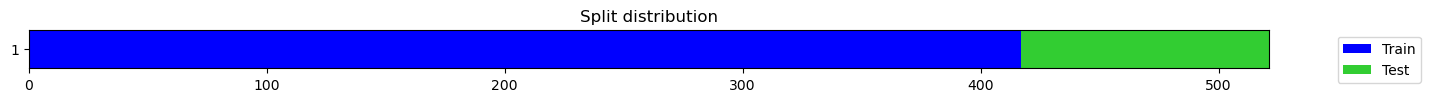

Split --> 417


In [22]:
#| export
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train
if verbose > 0: print("len(X): ", len(X));
if config.analysis_mode == 'online':
    if verbose > 0: print("--> Split 1")
    splits = TimeSplitter(valid_size=0.2, show_plot=show_plots)(X)
elif config.analysis_mode == 'offline':
    if verbose > 0: print("--> Split 2")
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size, show_plot = show_plots)
if verbose > 0: 
    print("Split -->", len(splits[0]))


In [23]:
#| hide
if verbose > 0: 
    print(X.shape)
    display(splits)

(521, 3, 30)


((#417) [0,1,2,3,4,5,6,7,8,9...],
 (#104) [417,418,419,420,421,422,423,424,425,426...])

## Moirai - Load model & get embeddings
For using Moirai Forecast we need the following information:
- ``module``: pre-trained model
- ``prediction_length``: number of timesteps to predict
- ``context_length``: number of known timesteps used for the prediction
- ``patch_size``: size for the basic unit for the model (input token size). Similar to 'word', 'paragraph', ... for LLMs.
- ``num_samples``: number of prediction to do (for taking statistics)
- ``target_dim``: total number of features to predict
- ``feat_dynamic_real_dim``: features that change with time
- ``past_feat_dynamic_real_dim``: features known to change along time in the past

### Set callback list

### Get data loaders

In [24]:
#| export
tfms = [ToFloat(), None]
batch_tfms = [
    TSStandardize(
        by_sample=config.norm_by_sample, 
        use_single_batch=config.norm_use_single_batch
    )
]

In [25]:
#| export
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
if verbose > 0: print("get dls -->")

get dls -->


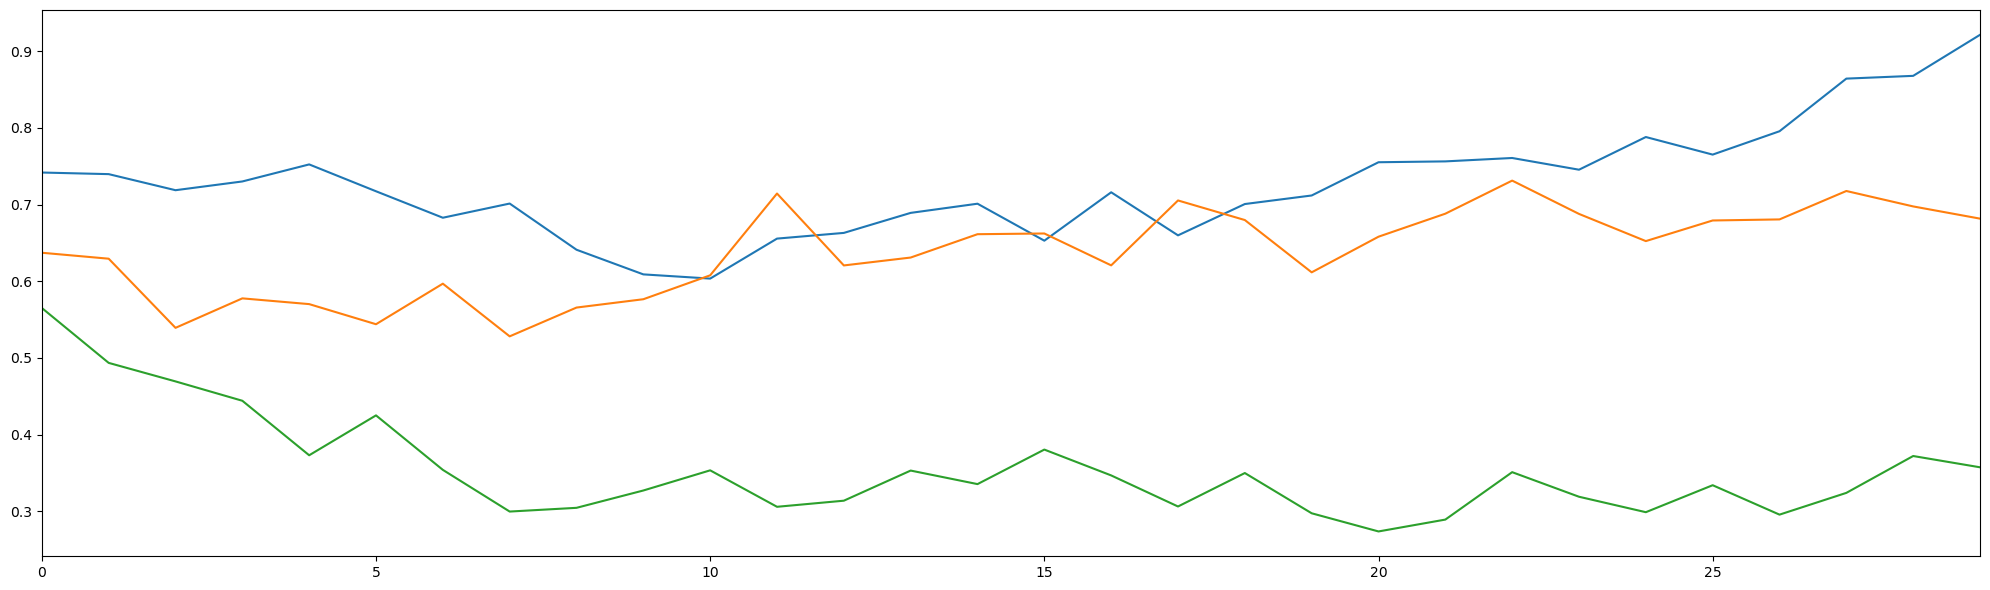

None

In [26]:
#| hide
if show_plots: display(dls.show_at(0))

### Build MVP TS Learner

--> Conjetura: 
- Context: el tamaño total
- prediction_length: el tamaño de nuestras ventanas originales (para que aprenda información de ese tamaño)
- patch_size: lo dejo en 'auto' para que elija el que más convenga
- batch_size: determines the number of samples that can be inferred in parallel. | ¿Se refiere al número de ventanas o al número de predicciones que saca?

In [27]:
X.shape

(521, 3, 30)

In [28]:
model_size = 'small'
prediction_length = X.shape[2]
context_length = df_train.shape[0]
patch_size = 'auto'
batch_size = 32
test_size = int(config.valid_size*df_train.shape[0])

In [29]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df_train))
# split into train/test set
train, test_template = split(
    ds, offset = - test_size
) #assign last test-size time steps as test set

In [30]:
# Construct rolling window evaluation
test_data            = test_template.generate_instances(
    prediction_length=prediction_length,  # number of time steps for each prediction
    windows          = test_size // prediction_length,  # number of windows in rolling window evaluation
    distance         = config.stride,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [31]:
# Prepare pre-trained model by downloading model weights from huggingface hub
timer = dvats.utils.Time()
timer.start()
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{model_size}"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=patch_size,
    num_samples=100,
    target_dim=1, #X.shape[1]
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)
timer.end()
timer.show()

[] Start: 1727273363.6003273 | End: 1727273364.3953886 | Duration: 0.7950613498687744 seconds


0.7950613498687744

### Show predictions

In [32]:
model.eval()
predictor = model.create_predictor(batch_size = batch_size)
forecasts = predictor.predict(test_data.input)

In [33]:
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

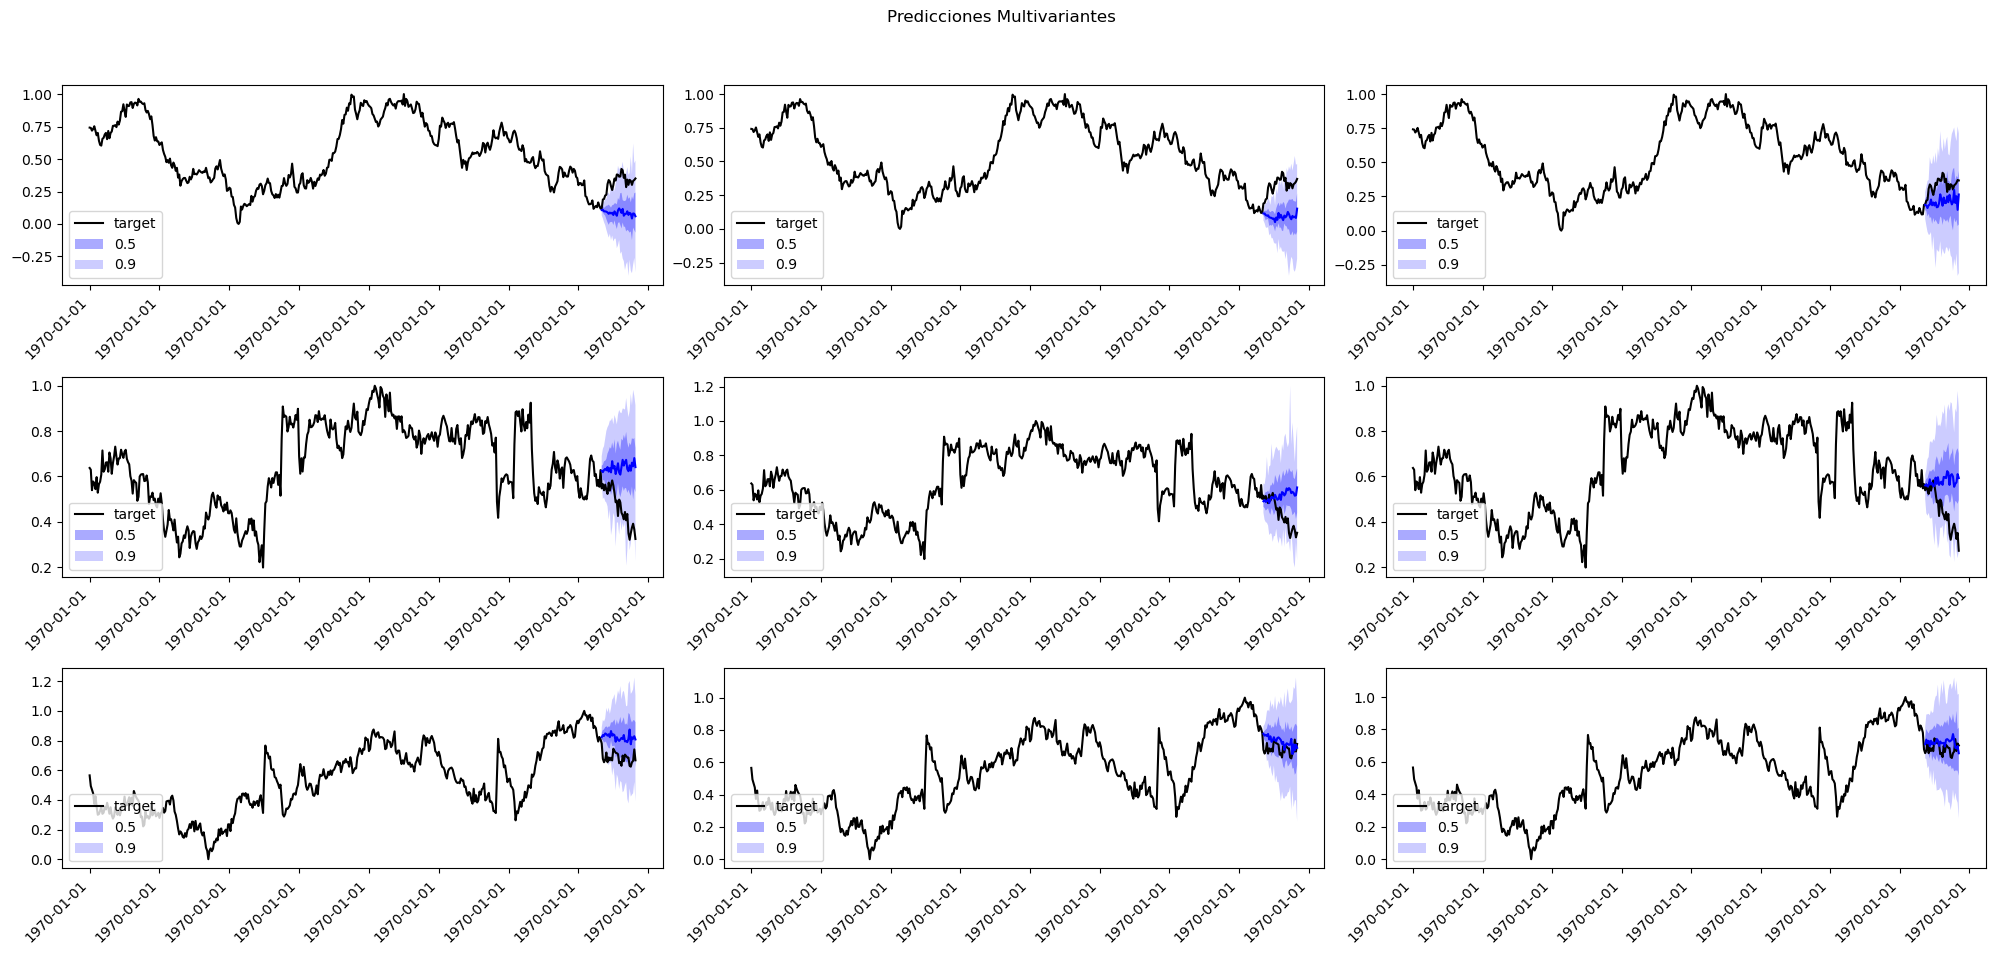

In [34]:
# Suponiendo que tienes 3 variables y quieres visualizar 5 predicciones
fig, axes = plt.subplots(3, 3, figsize=(20, 10))  # 3 filas (una por variable), 5 columnas (una por predicción)
fig.suptitle('Predicciones Multivariantes')

# Llamada a plot_next_multi
plot_next_multi(
    axes=axes,
    input_it=input_it,  # Asegúrate de que este iterador proporcione los datos correctos
    label_it=label_it,
    forecast_it=forecast_it,
    context_length=context_length,
    intervals=(0.5, 0.9),  # Intervalos de confianza
    show_label=True
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Example mask

#### Create mask

In [35]:
#| hide
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

#### Show mask

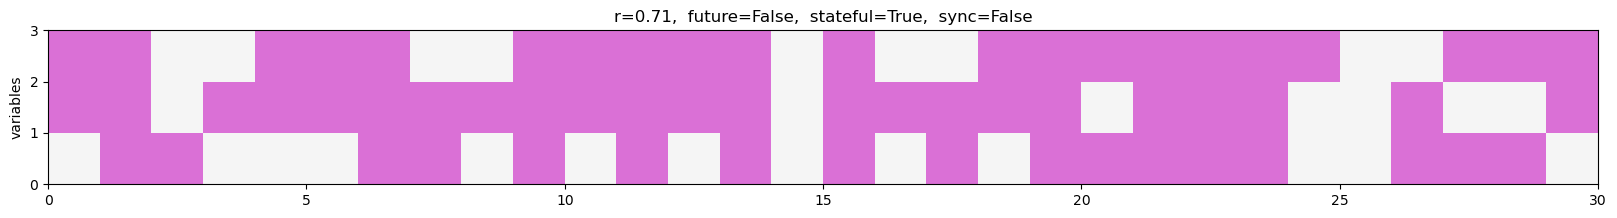

In [36]:
#| hide
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

### Train the model

In [37]:
timer = ut.Time()
timer.start()

1727273367.6577857

In [38]:
#| export
if verbose > 0: print("--> Train")
res = learn.init()

--> Train


NameError: name 'learn' is not defined

In [ ]:
timer.end()
timer.show()

#### Validate the model

--> To do: ver cómo hacerlo

In [ ]:
#| export
if verbose > 0: print("Train -->")
#learn.validate()
if verbose > 0: print("Validate -->")

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [ ]:
#| export
# Log the learner without the datasets
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            learn, 
            f'moirai', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [ ]:
#| export
if verbose > 0: print("Artifact logged | About to finish run")
run.finish()

In [ ]:
#| export
if verbose > 0: print("Execution ended")
from dvats.imports import beep
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [ ]:
#| hide
if reset_kernel:
    import os
    os._exit(00)